You should be able to `run all cells` and the notebook should execute to completion. Just the train set itself is 18GB so the download of the files might take a while.

You have to make sure the PATH you give below exists and the notebook should be able to take it from there.

[Official website of the COCO dataset](http://cocodataset.org)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from utils import *

from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from matplotlib import patches, patheffects

In [3]:
print_info()

Last run on: 2018-03-27
PyTorch version: 0.3.1.post2
fastai version: 0.6


In [4]:
PATH = Path('data/coco2017')

In [5]:
# %%capture
# !wget http://images.cocodataset.org/zips/train2017.zip -P {PATH}
# !wget http://images.cocodataset.org/zips/val2017.zip -P {PATH}
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {PATH}

In [6]:
# %%capture
# for d in PATH.iterdir():
#     !unzip {d} -d {PATH}

In [7]:
train_anno = json.load((PATH/'annotations/instances_train2017.json').open())

In [8]:
train_anno.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [9]:
train_anno['images'][:2]

[{'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
  'date_captured': '2013-11-14 11:18:45',
  'file_name': '000000391895.jpg',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'height': 360,
  'id': 391895,
  'license': 3,
  'width': 640},
 {'coco_url': 'http://images.cocodataset.org/train2017/000000522418.jpg',
  'date_captured': '2013-11-14 11:38:44',
  'file_name': '000000522418.jpg',
  'flickr_url': 'http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg',
  'height': 480,
  'id': 522418,
  'license': 4,
  'width': 640}]

In [10]:
im_idx2fn = {anno['id']: anno['file_name'] for anno in train_anno['images']}

In [11]:
get_from_dict(im_idx2fn, 4)

{184613: '000000184613.jpg',
 318219: '000000318219.jpg',
 391895: '000000391895.jpg',
 522418: '000000522418.jpg'}

In [12]:
train_anno['annotations'][0]

{'area': 2765.1486500000005,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156,
 'image_id': 558840,
 'iscrowd': 0,
 'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]]}

In [13]:
len(train_anno['images']), len(train_anno['annotations'])

(118287, 860001)

In [14]:
train_anno['categories'][:3]

[{'id': 1, 'name': 'person', 'supercategory': 'person'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'},
 {'id': 3, 'name': 'car', 'supercategory': 'vehicle'}]

In [15]:
len(train_anno['categories'])

80

In [16]:
idx2cat = {o['id']: o['name'] for o in train_anno['categories']}

In [17]:
get_from_dict(idx2cat, 4)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle'}

In [18]:
idx2anno = {(anno['image_id'], anno['category_id']): anno for anno in train_anno['annotations']}

The point of this notebook is so that I can practice what was covered in [Lecture 8](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb) of the Fastai course part 2 v2.

What I am looking for here is really a toy dataset - no point using everything in COCO 2017. Also, I will try to put a twist on what is predicted. 

In [19]:
from collections import Counter

In [20]:
c = Counter(anno['category_id'] for anno in train_anno['annotations'])
for idx, count in c.most_common():
    print(idx, '{:15s}'.format(idx2cat[idx]), count, sep='\t')

1	person         	262465
3	car            	43867
62	chair          	38491
84	book           	24715
44	bottle         	24342
47	cup            	20650
67	dining table   	15714
51	bowl           	14358
10	traffic light  	12884
31	handbag        	12354
28	umbrella       	11431
16	bird           	10806
9	boat           	10759
8	truck          	9973
15	bench          	9838
20	sheep          	9509
52	banana         	9458
38	kite           	9076
4	motorcycle     	8725
27	backpack       	8720
64	potted plant   	8652
21	cow            	8147
46	wine glass     	7913
57	carrot         	7852
49	knife          	7770
56	broccoli       	7308
60	donut          	7179
2	bicycle        	7113
35	skis           	6646
86	vase           	6613
19	horse          	6587
32	tie            	6496
77	cell phone     	6434
55	orange         	6399
61	cake           	6353
37	sports ball    	6347
85	clock          	6334
33	suitcase       	6192
50	spoon          	6165
42	surfboard      	6126
6	bus            	6069
53	apple 

# Giraffe or traffic light?

In [21]:
from collections import defaultdict

In [22]:
ims2cats = defaultdict(list)

In [23]:
GIRAFFE = 25; TRAFFIC_LIGHT = 10
for anno in train_anno['annotations']:
    if anno['category_id'] in [GIRAFFE, TRAFFIC_LIGHT]:
        ims2cats[anno['image_id']].append(anno['category_id'])

In [24]:
im_idxs = defaultdict(list)

In [25]:
for idx in [GIRAFFE, TRAFFIC_LIGHT]:
    for k, v in ims2cats.items():
        if v[0] == idx and len(v) == 1:
            im_idxs[idx].append(k)

In [26]:
get_from_dict(idx2anno, 1)

{(558840, 58): {'area': 2765.1486500000005,
  'bbox': [199.84, 200.46, 77.71, 70.88],
  'category_id': 58,
  'id': 156,
  'image_id': 558840,
  'iscrowd': 0,
  'segmentation': [[239.97,
    260.24,
    222.04,
    270.49,
    199.84,
    253.41,
    213.5,
    227.79,
    259.62,
    200.46,
    274.13,
    202.17,
    277.55,
    210.71,
    249.37,
    253.41,
    237.41,
    264.51,
    242.54,
    261.95,
    228.87,
    271.34]]}}

In [27]:
giraffe_annos = [idx2anno[(idx, GIRAFFE)] for idx in im_idxs[GIRAFFE]]
traffic_light_annos = [idx2anno[(idx, TRAFFIC_LIGHT)] for idx in im_idxs[TRAFFIC_LIGHT]]

In [28]:
len(giraffe_annos), len(traffic_light_annos)

(1146, 1210)

In [29]:
annos = giraffe_annos[:1000] +  traffic_light_annos[:1000]

In [30]:
def draw_im_from_idx(idx, ax=None):
    if ax is None: _, ax = plt.subplots()
    ax.imshow(open_image(PATH/f'train2017/{im_idx2fn[idx]}'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [31]:
def draw_outline(patch):
    patch.set_path_effects([patheffects.Stroke(linewidth=3, foreground='black'),
                       patheffects.Normal()])

In [32]:
def draw_bb(bb, ax):
    rect = ax.add_patch(patches.Rectangle(bb[0:2], bb[2], bb[3], fill=False, linewidth=1, color='white'))
    draw_outline(rect)

In [33]:
def draw_label(x, y, label, ha='left'):
    text = ax.text(x, y, label, color='white', ha=ha, va='bottom', size=12)
    draw_outline(text)

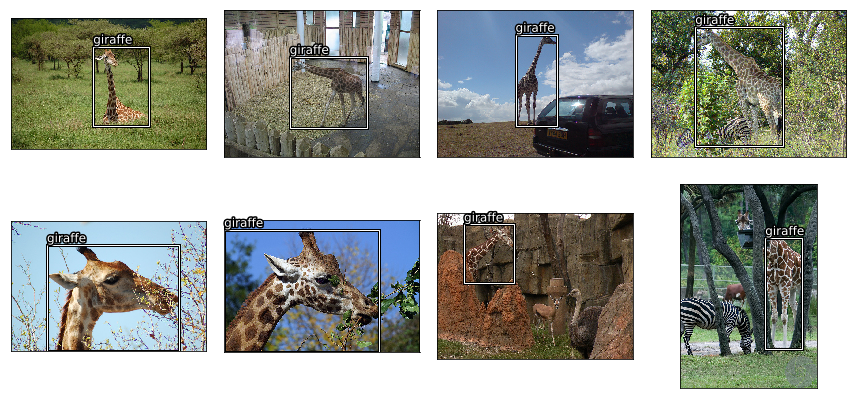

In [34]:
im_idxs = [anno['image_id'] for anno in annos[992:1000]]
bbs = [anno['bbox'] for anno in annos[992:1000]]

fig, ax = plt.subplots(2, 4, figsize=(12,6))
for idx, bb, ax in zip(im_idxs, bbs, ax.flatten()):
    draw_im_from_idx(idx, ax)
    draw_bb(bb, ax)
    draw_label(*bb[0:2], 'giraffe')
fig.tight_layout()

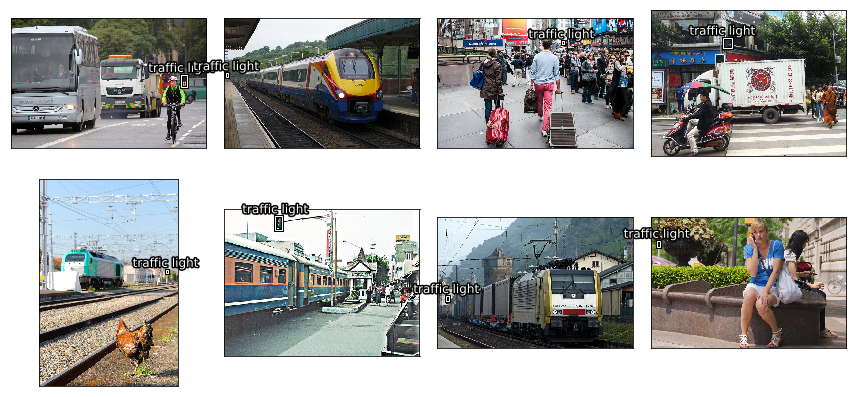

In [35]:
im_idxs = [anno['image_id'] for anno in annos[1992:2000]]
bbs = [anno['bbox'] for anno in annos[1992:2000]]

fig, ax = plt.subplots(2, 4, figsize=(12,6))
for idx, bb, ax in zip(im_idxs, bbs, ax.flatten()):
    draw_im_from_idx(idx, ax)
    draw_bb(bb, ax)
    draw_label(*bb[0:2], 'traffic light', 'center')
fig.tight_layout()

This is nice but it feels very much like what we did in class. I went for two classes so that I can use sigmoid and not softmax.

Maybe instead of predicting the bounding box the model could predict the center of the object, just to mix things up a little bit.

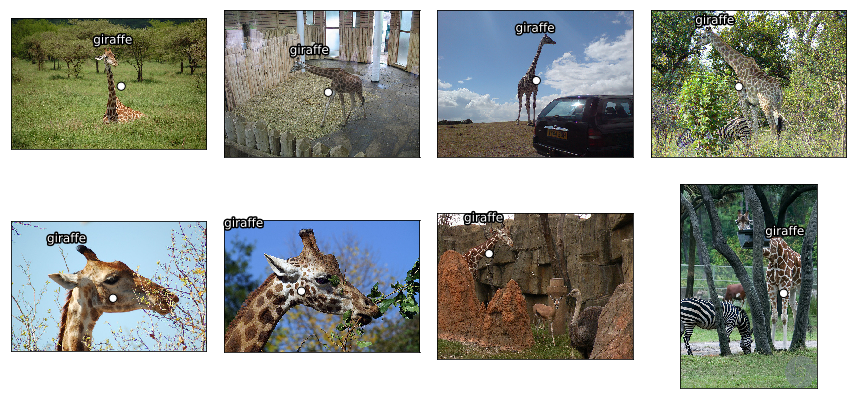

In [36]:
im_idxs = [anno['image_id'] for anno in annos[992:1000]]
bbs = [anno['bbox'] for anno in annos[992:1000]]

fig, ax = plt.subplots(2, 4, figsize=(12,6))
for idx, bb, ax in zip(im_idxs, bbs, ax.flatten()):
    draw_im_from_idx(idx, ax)
    circle = ax.add_patch(patches.Circle((bb[0] + bb[2]/2, bb[1] + bb[3]/2), radius=10, fill=True, linewidth=1, color='white'))
    draw_outline(circle)
    draw_label(*bb[0:2], 'giraffe')
fig.tight_layout()

This doesn't seem to look all that great. Center of bb =/= 'center' of object. I would probably have to do something fancy with the segmentation coordinates to calculate something more useful, but I do not think there is a point in doing so. Will stick to the bounding box.

###  Predicting the class and bounding box

The fastai library is very smart in that it provides data augmentation that works with bounding boxes (or more generally, coordinates)!

But it expects the bounding box to be defined as a set of points (upper right hand corner, lower left hand corner or the other two corners should also work, I think).

Let's get the dataloaders up and running and see if we can figure out how to feed them data.

In [37]:
def bb2fastai(bb):
    return [bb[0], bb[1], bb[0]+bb[2], bb[1]+bb[3]]

In [38]:
dataset = []
for anno in annos[:5]:
    dataset.append([im_idx2fn[anno['image_id']], int(anno['category_id']==25), bb2fastai(anno['bbox'])])

In [39]:
dataset[0]

['000000058223.jpg', 1, [29.29, 127.37, 219.67, 273.05]]

Quite annoyingly, for images 0, 0 is the upper left hand corner, not the lower one. I don't recall what fastai expects, but I don't think it should make any difference as we are effectively transforming coords of 2 separate points in a 2D plane. 

Oh well - let's verify to see whether I will have to eat my hat on this one or not.

In [40]:
df = pd.DataFrame(dataset, columns=['fn', 'label', 'coords'])

In [41]:
df['coords'] = df['coords'].apply(lambda lst: ' '.join(str(f) for f in lst))

In [42]:
df[['fn', 'label']].to_csv(PATH/'classes.csv', index=False)
df[['fn', 'coords']].to_csv(PATH/'bboxes.csv', index=False)

In [43]:
f_model = resnet34

In [44]:
df

fn  label                                 coords
0  000000058223.jpg      1             29.29 127.37 219.67 273.05
1  000000054305.jpg      1              236.88 22.74 384.0 540.26
2  000000209015.jpg      1               53.21 76.22 425.0 527.82
3  000000315018.jpg      1  271.56 15.69 525.4300000000001 334.88
4  000000179930.jpg      1  259.18 150.1 370.5 299.54999999999995

In [45]:
md = ImageClassifierData.from_csv(
    PATH,
    'train2017',
    PATH/'classes.csv',
    tfms=tfms_from_model(f_model, 224, crop_type=CropType.NO)
)

In [46]:
batch = next(iter(md.trn_dl))

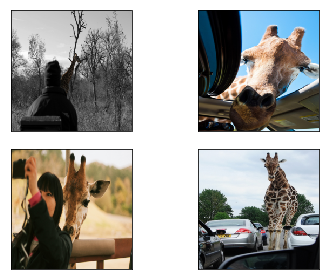

In [47]:
fig, axs = plt.subplots(2, 2)
for im, ax in zip(md.val_ds.denorm(to_np(batch[0])), axs.flatten()):
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()

In [48]:
md2 = ImageClassifierData.from_csv(
    PATH,
    'train2017',
    PATH/'bboxes.csv',
    tfms=tfms_from_model(f_model, 224, crop_type=CropType.NO, tfm_y=TfmType.COORD),
    continuous=True,
)

In [49]:
batch = next(iter(md2.trn_dl))

In [50]:
batch[1]


 136   53  193  104
 143    6  222  116
  84   11  134  222
  19   41  148  222
[torch.cuda.FloatTensor of size 4x4 (GPU 0)]

In [51]:
def bb_hw(bb):
    return [bb[0], bb[1], bb[2] - bb[0], bb[3] - bb[1]]

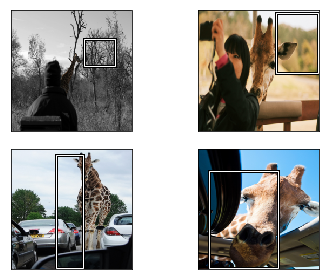

In [52]:
fig, axs = plt.subplots(2, 2)
for im, bb, ax in zip(md.trn_ds.denorm(to_np(batch[0])), to_np(batch[1]), axs.flatten()):
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    draw_bb(bb_hw(bb), ax)
fig.tight_layout()

Right, so I was wrong. Apparently bboxes for COCO are [<x_coord>, <y_coord>, width, height], but fastai expects them to be top-left, bottom-right coords (2 points) with the first coord being the y coordinate (to mimic the layout of a numpy array).

In [53]:
def bb2fastai(bb):
    return [bb[1], bb[0], bb[1]+bb[3], bb[0]+bb[2]] # <- needed to change the ordering here

dataset = []
for anno in annos[:5]:
    dataset.append([im_idx2fn[anno['image_id']], int(anno['category_id']==25), bb2fastai(anno['bbox'])])
    
df = pd.DataFrame(dataset, columns=['fn', 'label', 'coords'])

df['coords'] = df['coords'].apply(lambda lst: ' '.join(str(f) for f in lst))

df[['fn', 'label']].to_csv(PATH/'classes.csv', index=False)
df[['fn', 'coords']].to_csv(PATH/'bboxes.csv', index=False)

md = ImageClassifierData.from_csv(
    PATH,
    'train2017',
    PATH/'classes.csv',
    tfms=tfms_from_model(f_model, 224, crop_type=CropType.NO)
)

md2 = ImageClassifierData.from_csv(
    PATH,
    'train2017',
    PATH/'bboxes.csv',
    tfms=tfms_from_model(f_model, 224, crop_type=CropType.NO, tfm_y=TfmType.COORD),
    continuous=True,
)

def bb_hw(bb):
    return [bb[1], bb[0], bb[3] - bb[1], bb[2] - bb[0]]

In [54]:
batch = next(iter(md2.trn_dl))

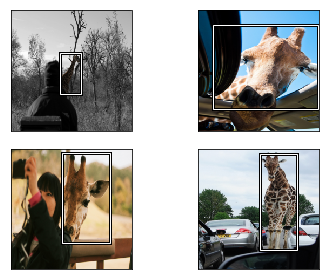

In [55]:
fig, axs = plt.subplots(2, 2)
for im, bb, ax in zip(md.trn_ds.denorm(to_np(batch[0])), to_np(batch[1]), axs.flatten()):
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    draw_bb(bb_hw(bb), ax)
fig.tight_layout()

Now the trick is to see if this will work with data augmentations.

In [56]:
md2 = ImageClassifierData.from_csv(
    PATH,
    'train2017',
    PATH/'bboxes.csv',
    tfms=tfms_from_model(f_model, 224, aug_tfms=[RandomRotate(60)], crop_type=CropType.NO, tfm_y=TfmType.COORD),
    continuous=True
)

In [57]:
batch = next(iter(md2.trn_dl))

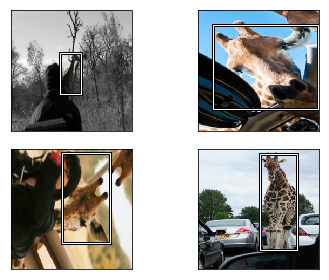

In [58]:
fig, axs = plt.subplots(2, 2)
for im, bb, ax in zip(md.trn_ds.denorm(to_np(batch[0])), to_np(batch[1]), axs.flatten()):
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    draw_bb(bb_hw(bb), ax)
fig.tight_layout()

So it doesn't work with the augmentations. It probably could be made to work by overriding the transform_coord method in a descendant class. I am not sure what level of effort it would take to implement this for say RandomRotate but would be a fun activity to try and might give one an edge in a Kaggle competition, etc.

```Python
class Transform():
    """ A class that represents a transform.

    All other transforms should subclass it. All subclasses should override
    do_transform.
    We have 3 types of transforms:
       TfmType.NO: the target y is not transformed
       TfmType.PIXEL: assumes x and y are images of the same (cols, rows) and trasforms
           them with the same paramters.
       TfmType.COORD: assumes that y are some coordinates in the image x.

    Arguments:
        tfm_y (TfmType): type of transform
    """
    def __init__(self, tfm_y=TfmType.NO):
        self.tfm_y=tfm_y
        self.store = threading.local()

    def set_state(self): pass

    def __call__(self, x, y):
        self.set_state()
        x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
                else self.transform(x,y) if self.tfm_y==TfmType.PIXEL
                else self.transform_coord(x,y))
        return x, y

    def transform_coord(self, x, y): return self.transform(x),y
```

Anyhow, as the plan is to get this to work I will skip data augmentation (upon checking this is what was done in the lecture notebook as well - I saw the side on transforms and assumed they were used across the board, turns out they were only used for image classification)

Now the key part - concatenating the datasets. This would be trivial to copy from the lecture notebook, but the steer clear from that, here is the Dataset definition from PyTorch that should suffice as a template:

```Python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```

In [59]:
type(md.trn_ds), type(md2.trn_ds)

(fastai.dataset.FilesIndexArrayDataset,
 fastai.dataset.FilesIndexArrayRegressionDataset)

In [60]:
class CombinedDataset():
    def __init__(self, ds1, ds2):
        self.ds1 = ds1
        self.ds2 = ds2
        
    def __getitem__(self, idx):
        return (self.ds1[idx][0], (self.ds1[idx][1], self.ds2[idx][1]))
    
    def __len__(self):
        return len(self.ds1)
    
    # we need this to be able to plot the results
    def denorm(self, arr):
        return self.ds1.denorm(arr)

In [61]:
trn_ds = CombinedDataset(md.trn_ds, md2.trn_ds)
val_ds = CombinedDataset(md.val_ds, md2.val_ds)

In [62]:
trn_ds[0][0].shape, len(trn_ds[0][1]), trn_ds[0][1][1].shape

((3, 224, 224), 2, (4,))

In [63]:
trn_ds[0][1]

(0, array([  9., 114., 188., 183.], dtype=float32))

In [64]:
# being extra sneaky here replacing the datasets
md.trn_dl.dataset = trn_ds
md.val_dl.dataset = val_ds

In [65]:
next(iter(md.trn_dl))[1]

[
  0
  0
  0
  0
 [torch.cuda.LongTensor of size 4 (GPU 0)], 
   79   91  155  129
   28   28  184  222
    9  114  188  183
    8   95  174  183
 [torch.cuda.FloatTensor of size 4x4 (GPU 0)]]

Let's pull it all together, create a dataset from all the images in the CSV file(s) and build the model.

##  Training the model

In [66]:
dataset = []
for anno in annos:
    dataset.append([im_idx2fn[anno['image_id']], int(anno['category_id']==25), bb2fastai(anno['bbox'])])
    
df = pd.DataFrame(dataset, columns=['fn', 'label', 'coords'])

df['coords'] = df['coords'].apply(lambda lst: ' '.join(str(f) for f in lst))

df[['fn', 'label']].to_csv(PATH/'classes.csv', index=False)
df[['fn', 'coords']].to_csv(PATH/'bboxes.csv', index=False)

val_idxs = get_cv_idxs(2000)

md = ImageClassifierData.from_csv(
    PATH,
    'train2017',
    PATH/'classes.csv',
    tfms=tfms_from_model(f_model, 224, crop_type=CropType.NO),
    val_idxs=val_idxs
)

md2 = ImageClassifierData.from_csv(
    PATH,
    'train2017',
    PATH/'bboxes.csv',
    tfms=tfms_from_model(f_model, 224, crop_type=CropType.NO, tfm_y=TfmType.COORD),
    continuous=True,
    val_idxs=val_idxs
)

In [67]:
trn_ds = CombinedDataset(md.trn_ds, md2.trn_ds)
val_ds = CombinedDataset(md.val_ds, md2.val_ds)

In [68]:
md.trn_dl.dataset = trn_ds
md.val_dl.dataset = val_ds

In [69]:
batch = next(iter(md.trn_dl))

In [70]:
batch[0][:4].shape

torch.Size([4, 3, 224, 224])

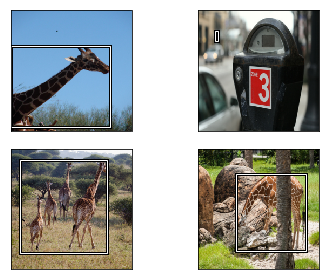

In [71]:
fig, axs = plt.subplots(2, 2)
for im, bb, ax in zip(md.trn_ds.denorm(to_np(batch[0][:4])), to_np(batch[1][1][:4]), axs.flatten()):
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    draw_bb(bb_hw(bb), ax)
fig.tight_layout()

Ok, this seems to work. Now time to construct the model.

In [82]:
# Blatantly stealing this from the lecture notebook. Not sure figuring this out myself would
# add much value and I need to finish this notebook at some point in time...
# Will define the cost functions myself though.

head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+1),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models, opt_fn=optim.Adam)

In [73]:
learn.models.model(VV(batch[0]))[:4]

Variable containing:
 0.2528  0.4731 -0.1549  1.5526  0.1594
 0.2938 -0.5614 -0.4267  0.3286  0.3224
 0.4743  0.7278 -0.5974 -0.7810 -0.9393
-0.6531  0.0312  0.0410 -0.1637  0.4374
[torch.cuda.FloatTensor of size 4x5 (GPU 0)]

In [74]:
def loss(x, y):
    classification_loss = F.binary_cross_entropy(F.sigmoid(x[:, 0]), y[0].float())
    bb_i = F.sigmoid(x[:, 1:]) * 224
    bb_loss = F.l1_loss(bb_i, y[1])
    return 1000 * classification_loss + bb_loss

In [83]:
learn.crit = loss

In [76]:
def accuracy(preds, targs):
    preds = preds[:, 0] > 0
    return (preds.long()==targs[0]).float().mean()

In [77]:
def classification_loss(preds, targs):
    return F.binary_cross_entropy(F.sigmoid(V(preds[:, 0])), V(targs[0].float())).data

def bb_loss(preds, targs):
    return F.l1_loss(F.sigmoid(V(preds[:, 1:])) * 224, V(targs[1])).data

In [78]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                           
    0      454.793821 377.374115



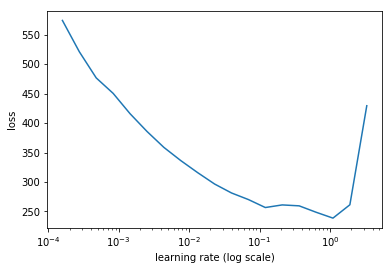

In [79]:
learn.sched.plot(5, 1)

In [84]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, metrics=[accuracy, classification_loss, bb_loss])

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   classification_loss bb_loss    
    0      134.979746 63.11137   0.988839   0.019559   43.552556 
    1      99.156411  53.614742  0.995536   0.018632   34.983077 
    2      81.706291  51.055958  0.995536   0.017543   33.512849 
    3      74.118448  55.334846  0.995536   0.020736   34.599306 
    4      61.766817  49.609596  0.993304   0.01574    33.869964 
    5      51.641937  47.774868  0.993304   0.016326   31.449307 
    6      45.449052  47.743931  0.993304   0.016241   31.503204 



[47.74393, 0.9933035714285714, 0.016240727322708284, 31.503204345703125]

In [86]:
preds = learn.predict()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


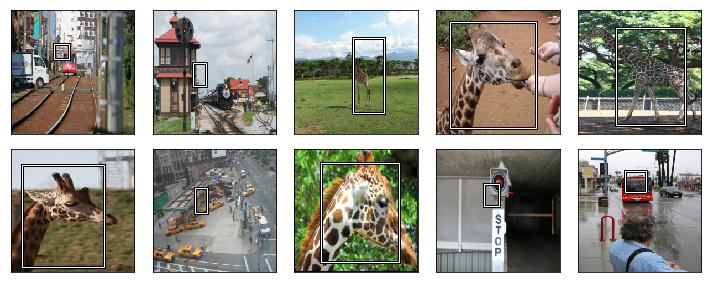

In [88]:
fig, axs = plt.subplots(2, 5, figsize=(10,4))
for im, bb, ax in zip([learn.data.val_ds.ds1[i][0] for i in range(10)], preds[:10, 1:], axs.flatten()):
    ax.imshow(md.trn_ds.denorm(im).squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    draw_bb(bb_hw(1/(1+np.exp(-bb)) * 224), ax)
fig.tight_layout()

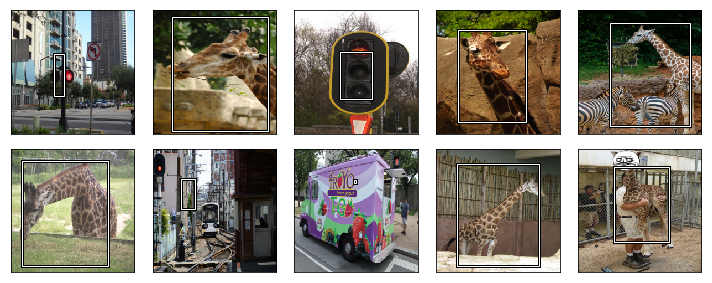

In [94]:
fig, axs = plt.subplots(2, 5, figsize=(10,4))
for im, bb, ax in zip([learn.data.val_ds.ds1[i][0] for i in range(10, 20)], preds[10:20, 1:], axs.flatten()):
    ax.imshow(md.trn_ds.denorm(im).squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    draw_bb(bb_hw(1/(1+np.exp(-bb)) * 224), ax)
fig.tight_layout()

Some of the images the NN got wrong

In [89]:
np.where((preds[:, 0] > 0) != learn.data.val_ds.ds1.y)

(array([ 24, 105, 171]),)

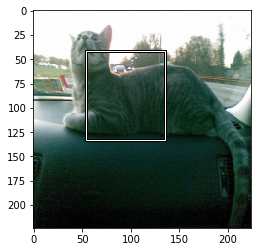

In [90]:
ax = plt.imshow(md.trn_ds.denorm(learn.data.val_ds.ds1[24][0]).squeeze())
draw_bb(bb_hw(1/(1+np.exp(-preds[24, 1:])) * 224), plt.gca())

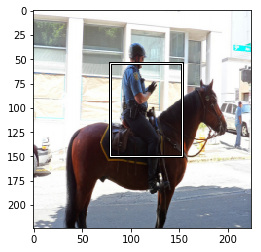

In [93]:
ax = plt.imshow(md.trn_ds.denorm(learn.data.val_ds.ds1[171][0]).squeeze())
draw_bb(bb_hw(1/(1+np.exp(-preds[171, 1:])) * 224), plt.gca())